# First steps

I am going to try some things from a github repository, so first, I will try to congfigure that part. Then, everything should run smoothly.

In [ ]:
# Cloning the repository
!git clone https://github.com/Tramac/awesome-semantic-segmentation-pytorch.git

# Change the working directory to the repository
import os
os.chdir('awesome-semantic-segmentation-pytorch')

# Remove some unnecessary libraries from requirements.txt
!sed -i '/math/d' requirements.txt
!sed -i '/pickle/d' requirements.txt
!sed -i '/logging/d' requirements.txt
!sed -i '/shutil/d' requirements.txt

# Install the dependencies
!pip install -q -r requirements.txt

# Add the repository directory to the Python path
import sys
sys.path.append(os.getcwd())

Cloning into 'awesome-semantic-segmentation-pytorch'...
remote: Enumerating objects: 1687, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 1687 (delta 0), reused 5 (delta 0), pack-reused 1678
Receiving objects: 100% (1687/1687), 1.75 MiB | 2.76 MiB/s, done.
Resolving deltas: 100% (1029/1029), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 53.1 MB/s eta 0:00:00


This is to add a folder in the drive in order to save the results in the end.

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Create a directory in Google Drive to save files
# TODO: change the saving directory if needed
save_dir = '/content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Creating the folder to save the models
models_dir = os.path.join(save_dir, 'Models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

# Creating the folder to save the results
results_dir = os.path.join(save_dir, 'Results')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

'''# Example: Save a test file
file_path = os.path.join(save_dir, 'my_file.txt')
with open(file_path, 'w') as f:
    f.write("Hello, this is a test file!")

# Example: Save a PyTorch model
# Assuming `model` is a PyTorch model you have defined
model = nn.Sequential(nn.Linear(2, 2), nn.ReLU(), nn.Linear(2, 1))  # Example model
model_save_path = os.path.join(save_dir, 'my_model.pth')
torch.save(model.state_dict(), model_save_path)

# Verify the files are saved
print(os.listdir(save_dir))'''


Mounted at /content/drive


'# Example: Save a test file\nfile_path = os.path.join(save_dir, \'my_file.txt\')\nwith open(file_path, \'w\') as f:\n    f.write("Hello, this is a test file!")\n\n# Example: Save a PyTorch model\n# Assuming `model` is a PyTorch model you have defined\nmodel = nn.Sequential(nn.Linear(2, 2), nn.ReLU(), nn.Linear(2, 1))  # Example model\nmodel_save_path = os.path.join(save_dir, \'my_model.pth\')\ntorch.save(model.state_dict(), model_save_path)\n\n# Verify the files are saved\nprint(os.listdir(save_dir))'

From this point onwards, everything should go as before.

In [ ]:
!pip install -q segmentation-models-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 10.5 MB/s eta 0:00:00


In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data as data
import copy
from torch.utils.data import DataLoader, Subset
import random
import torchvision.transforms as T
from torchvision.datasets import OxfordIIITPet
from tqdm.auto import tqdm
import segmentation_models_pytorch as smp
import time
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
import json
import gc
import torch.nn.functional as F
import pandas as pd

In [ ]:
random.seed(42)

In [ ]:
IMAGE_SIZE = (256,256)

# Data preparation

## Download and normalization

In [ ]:
mean_r, mean_g, mean_b = 0.42941532, 0.42954576, 0.42914987
std_r, std_g, std_b = 0.28511986, 0.28391948, 0.28198016

In [ ]:
transforms = T.Compose([T.Resize(IMAGE_SIZE, interpolation=T.InterpolationMode.NEAREST),
                        T.ToTensor(),
                        T.Normalize([mean_r, mean_g, mean_b], [std_r, std_g, std_b])])

target_transforms = T.Compose([T.Resize(IMAGE_SIZE, interpolation=T.InterpolationMode.NEAREST),
                               T.PILToTensor(),
                               T.Lambda(lambda x: (x - 1).long())])

In [ ]:
train_dataset = OxfordIIITPet('/datasets/pets',
                             transform=transforms,
                             split='trainval',
                             target_transform=target_transforms,
                             target_types='segmentation',
                             download = True)

test_dataset = OxfordIIITPet('/datasets/pets',
                             transform=transforms,
                             split='test',
                             target_transform=target_transforms,
                             target_types='segmentation',
                             download = True)

100%|██████████| 791918971/791918971 [00:32<00:00, 24459137.98it/s]


Extracting /datasets/pets/oxford-iiit-pet/images.tar.gz to /datasets/pets/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 10831887.19it/s]


Extracting /datasets/pets/oxford-iiit-pet/annotations.tar.gz to /datasets/pets/oxford-iiit-pet


In [ ]:
print(f"Number of samples in train dataset: {len(train_dataset)}")
print(f"Number of samples in testval dataset: {len(test_dataset)}")

Number of samples in train dataset: 3680
Number of samples in testval dataset: 3669


In [ ]:
train_dataset

Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: /datasets/pets
    StandardTransform
Transform: Compose(
               Resize(size=(256, 256), interpolation=nearest, max_size=None, antialias=True)
               ToTensor()
               Normalize(mean=[0.42941532, 0.42954576, 0.42914987], std=[0.28511986, 0.28391948, 0.28198016])
           )
Target transform: Compose(
                      Resize(size=(256, 256), interpolation=nearest, max_size=None, antialias=True)
                      PILToTensor()
                      Lambda()
                  )

Displaying some examples.

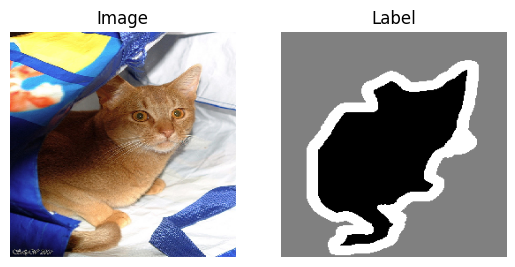

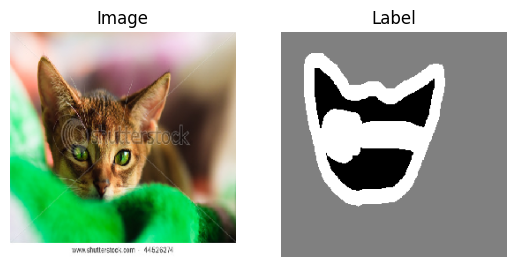

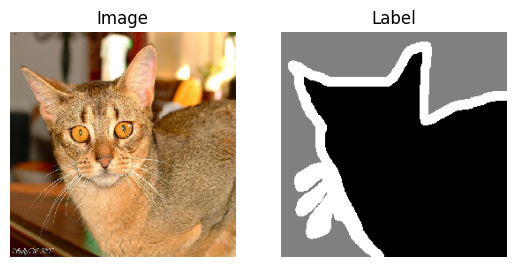

Images shape: torch.Size([3, 256, 256]), dtype: torch.float32
Labels shape: torch.Size([1, 256, 256]), dtype: torch.int64


In [ ]:
# Function to display an image and its corresponding label
def display_sample(dataset, idx, mean, std):
    # Reverse the normalization
    normalize = T.Compose([
        T.Normalize(mean=[0., 0., 0.], std=[1/std[0], 1/std[1], 1/std[2]]),
        T.Normalize(mean=[-mean[0], -mean[1], -mean[2]], std=[1., 1., 1.])])
    to_pil = T.ToPILImage()

    image, label = dataset[idx]
    # Reverse the normalization on the image
    image = normalize(image)

    # Convert tensors to numpy arrays for visualization
    image_np = image.permute(1, 2, 0).numpy()
    label_np = label.squeeze().numpy()  # Squeeze to remove channel dimension

    # Plot image and label
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(image_np)
    ax1.set_title('Image')
    ax1.axis('off')
    ax2.imshow(label_np, cmap='gray')
    ax2.set_title('Label')
    ax2.axis('off')
    plt.show()

# Mean and std values used for normalization during preprocessing
mean = [mean_r, mean_g, mean_b]
std = [std_r, std_g, std_b]

# Display a few samples
for i in range(3):
    display_sample(train_dataset, i, mean, std)

# Inspect data types and shapes
image, label = train_dataset[0]
print(f"Images shape: {image.shape}, dtype: {image.dtype}")
print(f"Labels shape: {label.shape}, dtype: {label.dtype}")


In [ ]:
# Defining a variable for the number of classes
num_classes = 3

## Data Augmentation

In [ ]:
class OxfordIIITPetsAugmented(OxfordIIITPet):
    def __init__(self, root: str, split: str,
                 target_types="segmentation", download=False,
                 pre_transform=None, post_transform=None,
                 pre_target_transform=None, post_target_transform=None,
                 common_transform=None):
        super().__init__(root=root, split=split,
                         target_types=target_types, download=download,
                         transform=pre_transform,
                         target_transform=pre_target_transform)
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # Common transforms
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)

In [ ]:
pre_transforms = T.ToTensor()

pre_target_transforms = T.PILToTensor()

train_common_transforms = T.Compose([T.Resize(IMAGE_SIZE, interpolation=T.InterpolationMode.NEAREST),
                                     T.RandomRotation(90, fill=2),
                                     T.RandomHorizontalFlip(0.5)])

train_post_transforms = T.Compose([T.ColorJitter(),
                                   T.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
                                   T.Normalize([mean_r, mean_g, mean_b], [std_r, std_g, std_b])])

train_post_target_transforms = T.Compose([T.Lambda(lambda x: (x - 1).long())])

In [ ]:
train_dataset_augmented = OxfordIIITPetsAugmented('/datasets/pets',
                                                  split='trainval',
                                                  pre_transform = pre_transforms,
                                                  pre_target_transform = pre_target_transforms,
                                                  common_transform=train_common_transforms,
                                                  post_transform = train_post_transforms,
                                                  post_target_transform = train_post_target_transforms,
                                                  target_types='segmentation')

In [ ]:
train_dataset = data.ConcatDataset([train_dataset,train_dataset_augmented])

## Train, Validation and Test split

In [ ]:
def create_validation_set(train_data, train_percentage, transforms= None):

  # Split train data into train and validation sets
  num_train_examples = int(len(train_data) * train_percentage)
  num_valid_examples = len(train_data) - num_train_examples

  # Create 'Subset' objects
  train_data, valid_data = data.random_split(train_data, [num_train_examples, num_valid_examples])

  print(f"Number training examples: {len(train_data)}")
  print(f"Number validation examples: {len(valid_data)}")

  # Apply transformations to the validation set
  valid_data = copy.deepcopy(valid_data)
  train_data = copy.deepcopy(train_data)

  return train_data, valid_data

In [ ]:
test_dataset, valid_dataset = create_validation_set(test_dataset, 0.5)

Number training examples: 1834
Number validation examples: 1835


In [ ]:
BATCH_SIZE = 32
NUM_WORKERS = 8
PIN_MEMORY = True

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          persistent_workers=True)

valid_loader = DataLoader(valid_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          persistent_workers=True)

test_loader = DataLoader(test_dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=NUM_WORKERS,
                         pin_memory=PIN_MEMORY,
                         persistent_workers=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Key function definitions

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

## Train, evaluate and visualize

Definition of the functions for one epoch.

In [ ]:
# Training definition for one epoch
def train(model, loader, optimizer, criterion, device, model_type='FCN'):

    train_loss = 0
    total = 0
    correct = 0

    model.train()

    # Iterates over the batches
    for x, y in tqdm(loader, desc='Training (current epoch)'):
    #for (x,y) in loader:

        bs = y.size(0)
        x, y = x.to(device), y.squeeze(1).to(device)

        optimizer.zero_grad()

        # The output is formatted in a different way depending on the type of model
        if model_type == 'DenseASPP':
          output = model(x)
        else:
          output = model(x)['out']

        loss = criterion(output.reshape(bs, num_classes, -1), y.reshape(bs, -1)) # Reshapes the output like (batch_size, classes, pixels)
        train_loss += loss.item()
        loss.backward()

        optimizer.step()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy

In [ ]:
# Evaluation definition for one epoch
@torch.inference_mode()
def evaluate(model, loader, criterion, device, model_type='FCN'):

    total_loss = 0
    total = 0
    correct = 0

    model.eval()

    # Iterates over the batches
    with torch.no_grad():
      for x, y in tqdm(loader, desc='Evaluation (current epoch)'):
      #for(x,y) in loader:

        bs = y.size(0)
        x, y = x.to(device), y.squeeze(1).to(device)

        # The output is formatted in a different way depending on the type of model
        if model_type == 'DenseASPP':
          output = model(x)
        else:
          output = model(x)['out']

        loss = criterion(output.reshape(bs, num_classes, -1), y.reshape(bs, -1))
        total_loss += loss.item()

        _, y_pred = output.max(dim=1)
        total += y.size(0) * y.size(1) * y.size(2)
        correct += (y == y_pred).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy

## Plotting the training and validation stats

In [ ]:
from IPython.display import clear_output

def plot_stats(train_loss, valid_loss, train_accuracy, valid_accuracy, title):

    plt.figure(figsize=(5, 4))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(5, 4))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()


In [ ]:
import numpy as np
from PIL import Image
from torchvision.utils import draw_segmentation_masks


@torch.inference_mode()
def visualize(model, batch, model_type='FCN', num_elements=5):
    model.eval()

    xs, ys = batch

    # These steps reverse the normalization applied at the preprocessing phase for a nice visualization
    normalize = T.Compose([T.Normalize(mean = [0., 0., 0.], std = [1/std_r, 1/std_g, 1/std_b]),
                          T.Normalize(mean = [-mean_r, -mean_g, -mean_b], std = [1., 1., 1.])])
    to_pil = T.ToPILImage()

    for i, (x, y) in enumerate(zip(xs, ys)):

        # The output is formatted in a different way depending on the type of model
        if model_type == 'DenseASPP':
          prediction = model(x.unsqueeze(0).cuda()).squeeze(0).max(dim=0)[1]
        else:
          prediction = model(x.unsqueeze(0).cuda())['out'].squeeze(0).max(dim=0)[1]

        fig, ax = plt.subplots(1, 3, figsize=(6, 2), facecolor='white')

       # mask = (y == 2)

        ax[0].imshow(to_pil(normalize(x)))
        ax[1].imshow(to_pil(y.to(torch.uint8)))
        ax[2].imshow(to_pil(prediction.to(torch.uint8)))
        #ax[3].imshow(draw_segmentation_masks((normalize(x)).to(torch.uint8), masks=mask, alpha=0.7))  # Pass reshaped mask

        ax[0].axis('off')
        ax[1].axis('off')
        ax[2].axis('off')
        #ax[3].axis('off')

        ax[0].set_title('Original image')
        ax[1].set_title('Segmentation mask')
        ax[2].set_title('Prediction')
        #ax[3].set_title('Prediction on original image')

        plt.subplots_adjust(wspace=0, hspace=0.1)
        plt.show()

        if i >= num_elements:
            break

## EarlyStopper and whole_train_valid_cycle

In [ ]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
def whole_train_valid_cycle(model, num_epochs, train_loader, valid_loader, test_loader, optimizer, criterion, device, title,
                            model_type='FCN', scheduler=None, save=False):

  # Initializing validation loss
  best_valid_loss = float('inf')

  # Initializing the lists to save the training stats
  train_loss_history, valid_loss_history = [], []
  train_accuracy_history, valid_accuracy_history = [], []

  # Initializing the early stopper
  early_stopper = EarlyStopper(patience=2, min_delta=0.005)

  #-----------------------------------------------------------------------------
  # Starting the training loop
  start_time_train = time.time()

  for epoch in range(num_epochs):
    start_time_epoch = time.time()

    train_loss, train_accuracy = train(model, train_loader, optimizer, criterion, device, model_type=model_type)
    valid_loss, valid_accuracy = evaluate(model, valid_loader, criterion, device, model_type=model_type)

    # Printing the current results
    end_time_epoch = time.time()

    print(f"Epoch: {epoch+1}/{num_epochs} -- Epoch Time: {end_time_epoch-start_time_epoch:.2f} s")
    print("---------------------------------")
    print(f"Train -- Loss: {train_loss:.3f}, Acc: {train_accuracy * 100:.2f}%")
    print(f"Val -- Loss: {valid_loss:.3f}, Acc: {valid_accuracy * 100:.2f}%\n")

    # Appending the results to the history
    train_loss_history.append(train_loss)
    valid_loss_history.append(valid_loss)

    train_accuracy_history.append(train_accuracy)
    valid_accuracy_history.append(valid_accuracy)

    # Updating the best_valid_loss and saving the best model
    if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss

      # Saving the model (if required by the user)
      if save==True:
        filename = title + '.pt'
        model_save_path = os.path.join(models_dir, filename)
        torch.save(model.state_dict(), model_save_path)
        print(f'Validation loss improved. Model saved as {model_save_path}')

    # Step the learning rate scheduler for the DenseASPP models
    if scheduler is not None:
      scheduler.step()

    if early_stopper.early_stop(valid_loss):
      break

    # Clear memory
    del train_loss, train_accuracy, valid_loss, valid_accuracy
    gc.collect()
    torch.cuda.empty_cache()

  end_time_train = time.time()
  training_time = end_time_train - start_time_train

  print("\n--------------------------------------------------------------")
  print('Final training results:')
  print(f'Total training time ({title}): {training_time:.2f} s')
  plot_stats(train_loss_history, valid_loss_history,
             train_accuracy_history, valid_accuracy_history,
             title)
  visualize(model, next(iter(valid_loader)), model_type=model_type)

In [ ]:
# Setup the loss function
loss_fn = nn.CrossEntropyLoss()
loss_fn = loss_fn.to(device)

Function to count the trainable parameters (used below in the models).

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

We also define a function to count the total parameters (including the non-trainable ones).

In [ ]:
def count_total_parameters(model: nn.Module) -> int:
    return sum(p.numel() for p in model.parameters())

# FCN - ResNet 50

## Model definition and setup

In [ ]:
title_FCNresnet50 = 'FCN - Resnet50 segmentation'

In [ ]:
from torchvision.models.segmentation import fcn_resnet50#, deeplabv3_resnet101, deeplabv3_resnet50
from torchvision.models.segmentation.fcn import FCNHead#, DeepLabHead

num_classes = 3

FCN_Res50 = fcn_resnet50(weights_backbone='DEFAULT')

for param in FCN_Res50.parameters():
    param.requires_grad = False

FCN_Res50.classifier = FCNHead(2048, num_classes)

FCN_Res50

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 94.5MB/s]


FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(FCN_Res50):,} trainable parameters.")

The model has 9,439,747 trainable parameters.


In [ ]:
print(f"The model has {count_total_parameters(FCN_Res50):,} (total) parameters.")

The model has 32,947,779 (total) parameters.


## Training the model

Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 1/10 -- Epoch Time: 172.14 s
---------------------------------
Train -- Loss: 0.396, Acc: 84.56%
Val -- Loss: 0.349, Acc: 86.06%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/FCN - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 2/10 -- Epoch Time: 170.35 s
---------------------------------
Train -- Loss: 0.339, Acc: 86.61%
Val -- Loss: 0.331, Acc: 87.01%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/FCN - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 3/10 -- Epoch Time: 170.20 s
---------------------------------
Train -- Loss: 0.325, Acc: 87.17%
Val -- Loss: 0.323, Acc: 87.18%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/FCN - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 4/10 -- Epoch Time: 171.61 s
---------------------------------
Train -- Loss: 0.314, Acc: 87.57%
Val -- Loss: 0.313, Acc: 87.80%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/FCN - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 5/10 -- Epoch Time: 172.57 s
---------------------------------
Train -- Loss: 0.305, Acc: 87.93%
Val -- Loss: 0.308, Acc: 87.84%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/FCN - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 6/10 -- Epoch Time: 171.95 s
---------------------------------
Train -- Loss: 0.299, Acc: 88.18%
Val -- Loss: 0.303, Acc: 88.11%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/FCN - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 7/10 -- Epoch Time: 173.24 s
---------------------------------
Train -- Loss: 0.291, Acc: 88.46%
Val -- Loss: 0.303, Acc: 88.18%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/FCN - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 8/10 -- Epoch Time: 171.69 s
---------------------------------
Train -- Loss: 0.287, Acc: 88.62%
Val -- Loss: 0.300, Acc: 88.25%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/FCN - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 9/10 -- Epoch Time: 169.83 s
---------------------------------
Train -- Loss: 0.281, Acc: 88.85%
Val -- Loss: 0.301, Acc: 88.25%



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 10/10 -- Epoch Time: 169.23 s
---------------------------------
Train -- Loss: 0.274, Acc: 89.12%
Val -- Loss: 0.295, Acc: 88.51%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/FCN - Resnet50 segmentation.pt

--------------------------------------------------------------
Final training results:
Total training time (FCN - Resnet50 segmentation): 1721.04 s


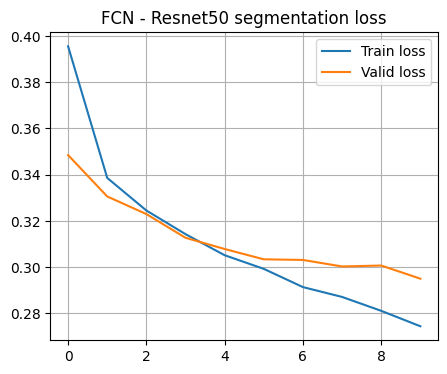

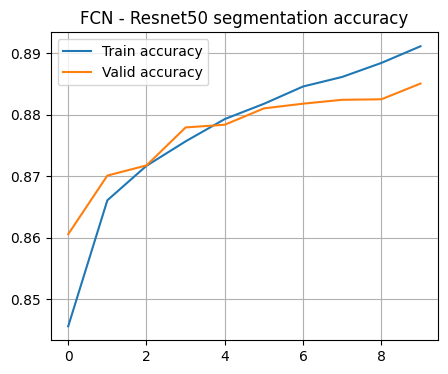

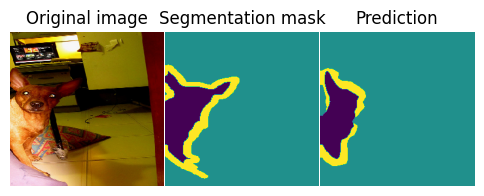

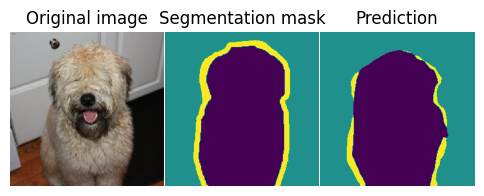

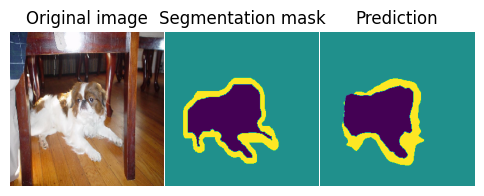

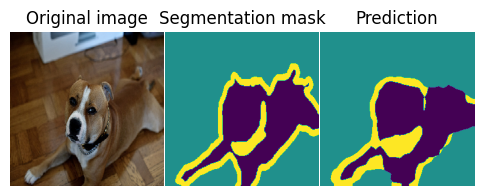

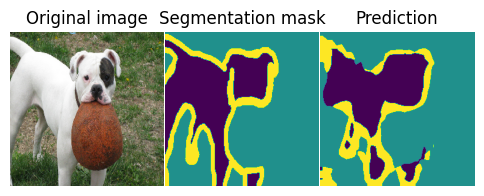

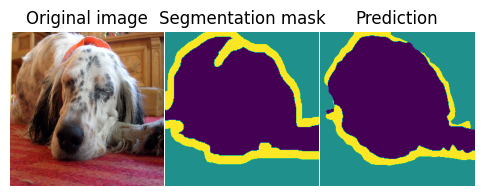

In [ ]:
N_EPOCHS = 10
optimizer_FCN = Adam(FCN_Res50.classifier.parameters(), lr=0.0019)

FCN_Res50 = FCN_Res50.to(device)

whole_train_valid_cycle(model=FCN_Res50,
                        num_epochs=N_EPOCHS,
                        train_loader=train_loader,
                        valid_loader=valid_loader,
                        test_loader=test_loader,
                        optimizer=optimizer_FCN,
                        criterion=loss_fn,
                        device=device,
                        title=title_FCNresnet50,
                        save=True)

# DeepLab - ResNet 50

## Model definition and setup

In [ ]:
title_Deeplabv3 = 'Deeplabv3 - Resnet50 segmentation'

In [ ]:
from torchvision.models.segmentation import deeplabv3_resnet50#, fcn_resnet50
from torchvision.models.segmentation.deeplabv3 import DeepLabHead

#num_classes = 3

DLab_Res50 = deeplabv3_resnet50(weights_backbone='DEFAULT')

DLab_Res50.aux_classifier = None
for param in DLab_Res50.parameters():
    param.requires_grad = False

DLab_Res50.classifier = DeepLabHead(2048, num_classes)

DLab_Res50

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"The model has {count_parameters(DLab_Res50):,} trainable parameters.")

The model has 16,126,211 trainable parameters.


In [ ]:
print(f"The model has {count_total_parameters(DLab_Res50):,} (total) parameters.")

The model has 39,634,243 (total) parameters.


## Training the model

Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 1/10 -- Epoch Time: 307.18 s
---------------------------------
Train -- Loss: 0.355, Acc: 85.88%
Val -- Loss: 0.314, Acc: 87.48%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/Deeplabv3 - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 2/10 -- Epoch Time: 307.94 s
---------------------------------
Train -- Loss: 0.292, Acc: 88.20%
Val -- Loss: 0.293, Acc: 88.43%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/Deeplabv3 - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 3/10 -- Epoch Time: 302.36 s
---------------------------------
Train -- Loss: 0.272, Acc: 88.96%
Val -- Loss: 0.285, Acc: 88.84%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/Deeplabv3 - Resnet50 segmentation.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 4/10 -- Epoch Time: 306.52 s
---------------------------------
Train -- Loss: 0.253, Acc: 89.63%
Val -- Loss: 0.292, Acc: 88.80%



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 5/10 -- Epoch Time: 304.13 s
---------------------------------
Train -- Loss: 0.241, Acc: 90.12%
Val -- Loss: 0.292, Acc: 88.96%


--------------------------------------------------------------
Final training results:
Total training time (Deeplabv3 - Resnet50 segmentation): 1532.06 s


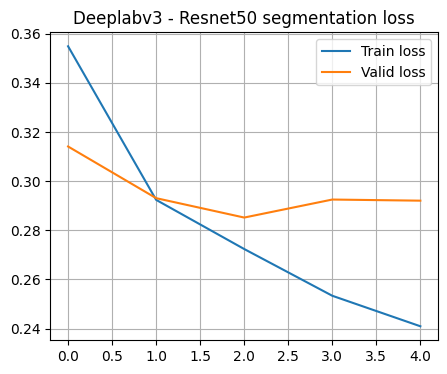

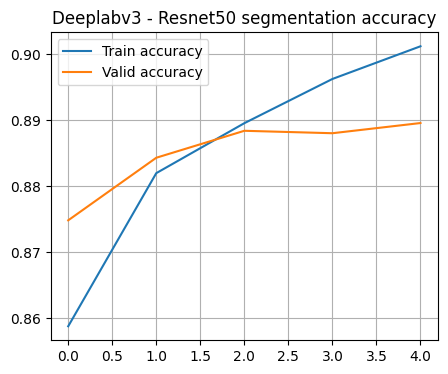

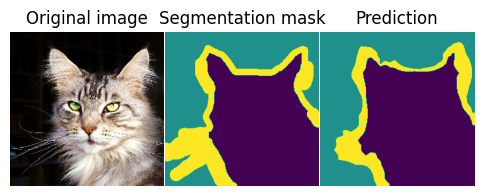

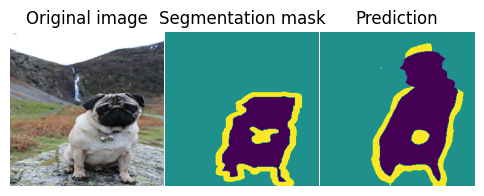

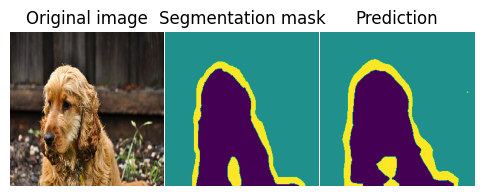

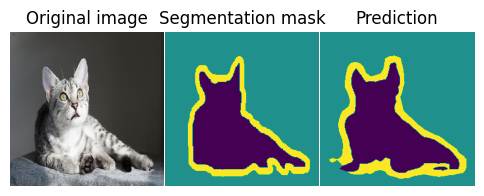

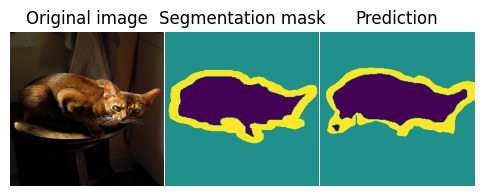

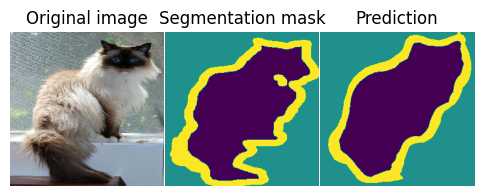

In [ ]:
N_EPOCHS = 10
optimizer_deeplab = Adam(DLab_Res50.classifier.parameters(), lr=0.0019)

DLab_Res50 = DLab_Res50.to(device)

whole_train_valid_cycle(model=DLab_Res50,
                        num_epochs=N_EPOCHS,
                        train_loader=train_loader,
                        valid_loader=valid_loader,
                        test_loader=test_loader,
                        optimizer=optimizer_deeplab,
                        criterion=loss_fn,
                        device=device,
                        title=title_Deeplabv3,
                        save=True)

# DenseASPP

Retreiving the part of the code relevant for the DenseASPP.

## Model definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from core.models.base_models.densenet import *
from core.models.fcn import _FCNHead

__all__ = ['DenseASPP', 'get_denseaspp', 'get_denseaspp_densenet121_citys',
           'get_denseaspp_densenet161_citys', 'get_denseaspp_densenet169_citys', 'get_denseaspp_densenet201_citys']

# Definition of the full DenseASPP class (the backbone + the head)
class DenseASPP(nn.Module):
    def __init__(self, nclass, backbone='densenet121', aux=False, jpu=False,
                 pretrained_base=True, dilate_scale=8, **kwargs):

        super(DenseASPP, self).__init__()
        self.nclass = nclass
        self.aux = aux
        self.dilate_scale = dilate_scale

        # Backbone definition
        if backbone == 'densenet121':
            self.pretrained = dilated_densenet121(dilate_scale, pretrained=pretrained_base, **kwargs)
        elif backbone == 'densenet161':
            self.pretrained = dilated_densenet161(dilate_scale, pretrained=pretrained_base, **kwargs)
        elif backbone == 'densenet169':
            self.pretrained = dilated_densenet169(dilate_scale, pretrained=pretrained_base, **kwargs)
        elif backbone == 'densenet201':
            self.pretrained = dilated_densenet201(dilate_scale, pretrained=pretrained_base, **kwargs)
        else:
            raise RuntimeError('unknown backbone: {}'.format(backbone))
        in_channels = self.pretrained.num_features

        # Adding the head (the core part defined in the paper)
        self.head = _DenseASPPHead(in_channels, nclass)

        self.__setattr__('exclusive', ['head'])

    def forward(self, x):
        size = x.size()[2:]
        features = self.pretrained.features(x)

        if self.dilate_scale > 8:
            features = F.interpolate(features, scale_factor=2, mode='bilinear', align_corners=True)
        outputs = []

        x = self.head(features)
        x = F.interpolate(x, size, mode='bilinear', align_corners=True)

        return x


class _DenseASPPHead(nn.Module):
    def __init__(self, in_channels, nclass, norm_layer=nn.BatchNorm2d, norm_kwargs=None, **kwargs):
        super(_DenseASPPHead, self).__init__()
        self.dense_aspp_block = _DenseASPPBlock(in_channels, 256, 64, norm_layer, norm_kwargs)
        self.block = nn.Sequential(
            nn.Dropout(0.1),
            # 5 means the amount of _DenseASPPConv
            nn.Conv2d(in_channels + 5 * 64, nclass, 1)
        )

    def forward(self, x):
        x = self.dense_aspp_block(x)
        return self.block(x)


class _DenseASPPConv(nn.Sequential):
    def __init__(self, in_channels, inter_channels, out_channels, atrous_rate,
                 drop_rate=0.1, norm_layer=nn.BatchNorm2d, norm_kwargs=None):
        super(_DenseASPPConv, self).__init__()
        self.add_module('conv1', nn.Conv2d(in_channels, inter_channels, 1)),
        self.add_module('bn1', norm_layer(inter_channels, **({} if norm_kwargs is None else norm_kwargs))),
        self.add_module('relu1', nn.ReLU(True)),
        self.add_module('conv2', nn.Conv2d(inter_channels, out_channels, 3, dilation=atrous_rate, padding=atrous_rate)),
        self.add_module('bn2', norm_layer(out_channels, **({} if norm_kwargs is None else norm_kwargs))),
        self.add_module('relu2', nn.ReLU(True)),
        self.drop_rate = drop_rate

    def forward(self, x):
        features = super(_DenseASPPConv, self).forward(x)
        if self.drop_rate > 0:
            features = F.dropout(features, p=self.drop_rate, training=self.training)
        return features


class _DenseASPPBlock(nn.Module):
    def __init__(self, in_channels, inter_channels1, inter_channels2,
                 norm_layer=nn.BatchNorm2d, norm_kwargs=None):
        super(_DenseASPPBlock, self).__init__()

        # Each _DenseASPPConv outputs inter_channels2 amount of units, since the
        # results are appended each time to the input, the input_size increases each time
        self.aspp_3 = _DenseASPPConv(in_channels, inter_channels1, inter_channels2, 3, 0.1,
                                     norm_layer, norm_kwargs)
        self.aspp_6 = _DenseASPPConv(in_channels + inter_channels2 * 1, inter_channels1, inter_channels2, 6, 0.1,
                                     norm_layer, norm_kwargs)
        self.aspp_12 = _DenseASPPConv(in_channels + inter_channels2 * 2, inter_channels1, inter_channels2, 12, 0.1,
                                      norm_layer, norm_kwargs)
        self.aspp_18 = _DenseASPPConv(in_channels + inter_channels2 * 3, inter_channels1, inter_channels2, 18, 0.1,
                                      norm_layer, norm_kwargs)
        self.aspp_24 = _DenseASPPConv(in_channels + inter_channels2 * 4, inter_channels1, inter_channels2, 24, 0.1,
                                      norm_layer, norm_kwargs)

    def forward(self, x):
        aspp3 = self.aspp_3(x)
        x = torch.cat([aspp3, x], dim=1)

        aspp6 = self.aspp_6(x)
        x = torch.cat([aspp6, x], dim=1)

        aspp12 = self.aspp_12(x)
        x = torch.cat([aspp12, x], dim=1)

        aspp18 = self.aspp_18(x)
        x = torch.cat([aspp18, x], dim=1)

        aspp24 = self.aspp_24(x)
        x = torch.cat([aspp24, x], dim=1)

        return x


# Function to get a specific instance of the model
def get_denseaspp(dataset='citys', backbone='densenet121', pretrained=False,
                  root='~/.torch/models', pretrained_base=True, **kwargs):
    r"""DenseASPP

    Parameters
    ----------
    dataset : str, default citys
        The dataset that model pretrained on. (pascal_voc, ade20k)
    pretrained : bool or str
        Boolean value controls whether to load the default pretrained weights for model.
        String value represents the hashtag for a certain version of pretrained weights.
    root : str, default '~/.torch/models'
        Location for keeping the model parameters.
    pretrained_base : bool or str, default True
        This will load pretrained backbone network, that was trained on ImageNet.
    Examples
    --------
    >>> model = get_denseaspp(dataset='citys', backbone='densenet121', pretrained=False)
    >>> print(model)
    """
    acronyms = {'pascal_voc': 'pascal_voc',
                'pascal_aug': 'pascal_aug',
                'ade20k': 'ade',
                'coco': 'coco',
                'citys': 'citys',}
    from core.data.dataloader import datasets
    model = DenseASPP(datasets[dataset].NUM_CLASS, backbone=backbone, pretrained_base=pretrained_base, **kwargs)
    if pretrained:
        from core.models.model_store import get_model_file
        device = torch.device(kwargs['local_rank'])
        model.load_state_dict(torch.load(get_model_file('denseaspp_%s_%s' % (backbone, acronyms[dataset]), root=root),
                              map_location=device))
    return model

In [ ]:
"""img = torch.randn(2, 3, 480, 480)
model1 = get_denseaspp('pascal_aug', 'densenet121')
outputs1 = model1(img)
outputs1"""

"img = torch.randn(2, 3, 480, 480)\nmodel1 = get_denseaspp('pascal_aug', 'densenet121')\noutputs1 = model1(img)\noutputs1"

In [ ]:
#outputs1.shape

In [ ]:
#type(outputs1)

## Optimizer setup (general)

In all DenseASPP models, I am using the same optimizer defined in the DenseASPP paper (Adam with these parameters), but it is instantiated each time since it depends on the number of parameters.

In [ ]:
N_EPOCHS = 10

In [ ]:
# Setup of the optimizer with initial learning rate and weight decay
initial_lr = 0.0003
weight_decay = 0.00001

In [ ]:
# Defining the learning rate scheduler
def lr_lambda(epoch, max_epochs=N_EPOCHS):
    return (1 - epoch / max_epochs) ** 0.9

## DenseASPP1

In [ ]:
title_denseaspp1 = 'DenseASPP1'

In [ ]:
# Getting one pretrained DenseASPP with densenet121 as backbone and pascal_aug as
# the dataset used for pretraining the DenseASPP head
model_denseaspp1 = get_denseaspp('pascal_aug', 'densenet121')

# Modifying the last classification layer
in_channels_last_layer = model_denseaspp1.head.block[1].in_channels
model_denseaspp1.head.block = nn.Sequential(nn.Dropout(0.1),
                                            nn.Conv2d(in_channels_last_layer, num_classes, 1))
model_denseaspp1

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 201MB/s]


DenseASPP(
  (pretrained): DilatedDenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, 

The approach will be to train all the head weights. All the parameters from the backbone are frozen.

In [ ]:
# Freeze the backbone weights
for param in model_denseaspp1.pretrained.parameters():
    param.requires_grad = False

# Ensure the head's parameters are trainable
for param in model_denseaspp1.head.parameters():
    param.requires_grad = True

# Optionally, verify that the parameters are correctly set
#for name, param in model_denseaspp1.named_parameters():
#    print(f"{name}: requires_grad={param.requires_grad}")

In [ ]:
def count_parameters(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [ ]:
print(f"The model has {count_parameters(model_denseaspp1):,} trainable parameters.")

The model has 2,220,675 trainable parameters.


In [ ]:
print(f"The model has {count_total_parameters(model_denseaspp1):,} (total) parameters.")

The model has 10,199,531 (total) parameters.


### Optimizer setup

General DenseASPP optimizer, using the amount of parameters of each model.

In [ ]:
optimizer_denseaspp1 = Adam(model_denseaspp1.parameters(), lr=initial_lr, weight_decay=weight_decay)

scheduler_denseaspp1 = LambdaLR(optimizer_denseaspp1, lr_lambda=lr_lambda)

### Training the model

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 1/10 -- Epoch Time: 150.89 s
---------------------------------
Train -- Loss: 0.381, Acc: 84.79%
Val -- Loss: 0.276, Acc: 89.08%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP1.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 2/10 -- Epoch Time: 157.08 s
---------------------------------
Train -- Loss: 0.268, Acc: 89.20%
Val -- Loss: 0.248, Acc: 90.23%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP1.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 3/10 -- Epoch Time: 151.20 s
---------------------------------
Train -- Loss: 0.247, Acc: 90.01%
Val -- Loss: 0.240, Acc: 90.69%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP1.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 4/10 -- Epoch Time: 149.83 s
---------------------------------
Train -- Loss: 0.232, Acc: 90.60%
Val -- Loss: 0.235, Acc: 90.97%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP1.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 5/10 -- Epoch Time: 150.67 s
---------------------------------
Train -- Loss: 0.223, Acc: 90.94%
Val -- Loss: 0.236, Acc: 90.99%



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 6/10 -- Epoch Time: 156.62 s
---------------------------------
Train -- Loss: 0.215, Acc: 91.23%
Val -- Loss: 0.229, Acc: 91.22%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP1.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 7/10 -- Epoch Time: 149.49 s
---------------------------------
Train -- Loss: 0.208, Acc: 91.50%
Val -- Loss: 0.228, Acc: 91.31%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP1.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 8/10 -- Epoch Time: 151.59 s
---------------------------------
Train -- Loss: 0.202, Acc: 91.74%
Val -- Loss: 0.227, Acc: 91.41%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP1.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 9/10 -- Epoch Time: 155.60 s
---------------------------------
Train -- Loss: 0.197, Acc: 91.92%
Val -- Loss: 0.226, Acc: 91.48%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP1.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 10/10 -- Epoch Time: 148.82 s
---------------------------------
Train -- Loss: 0.193, Acc: 92.07%
Val -- Loss: 0.223, Acc: 91.62%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP1.pt

--------------------------------------------------------------
Final training results:
Total training time (DenseASPP1): 1526.46 s


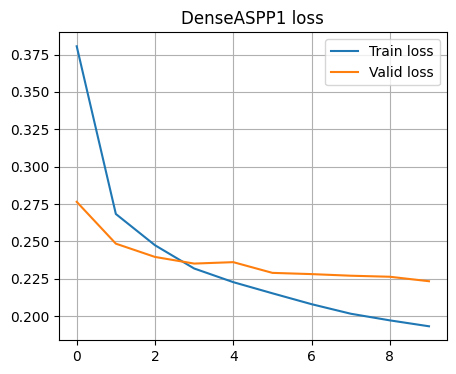

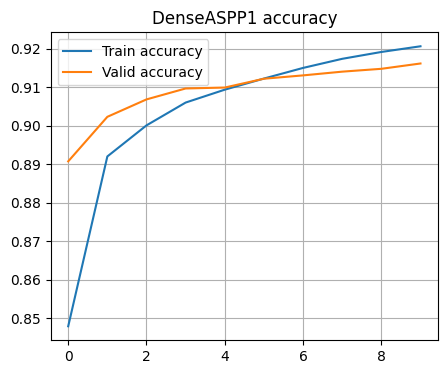

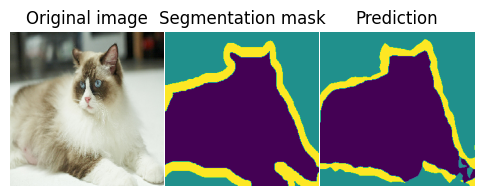

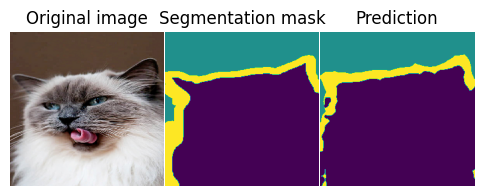

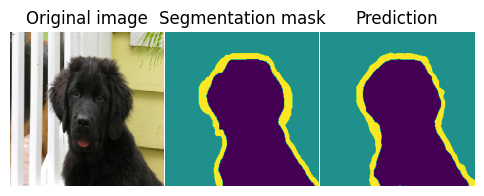

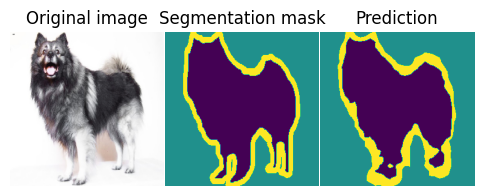

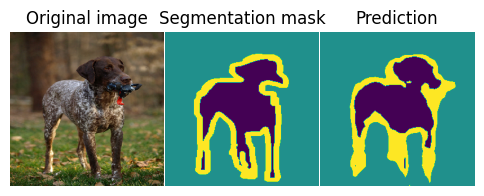

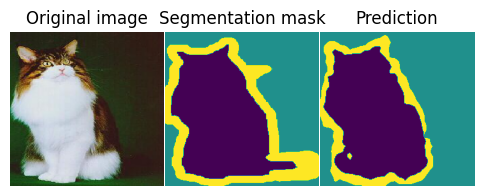

In [ ]:
model_denseaspp1 = model_denseaspp1.to(device)

whole_train_valid_cycle(model=model_denseaspp1,
                        num_epochs=N_EPOCHS,
                        train_loader=train_loader,
                        valid_loader=valid_loader,
                        test_loader=test_loader,
                        optimizer=optimizer_denseaspp1,
                        criterion=loss_fn,
                        device=device,
                        title=title_denseaspp1,
                        model_type='DenseASPP',
                        scheduler=scheduler_denseaspp1,
                        save=True)

## DenseASPP2

In [ ]:
title_denseaspp2 = 'DenseASPP2'

In [ ]:
# Getting one pretrained DenseASPP with densenet121 as backbone and ade20k as
# the dataset used for pretraining the DenseASPP head
model_denseaspp2 = get_denseaspp('ade20k', 'densenet121')

# Modifying the last classification layer
in_channels_last_layer = model_denseaspp2.head.block[1].in_channels
model_denseaspp2.head.block = nn.Sequential(nn.Dropout(0.1),
                                            nn.Conv2d(in_channels_last_layer, num_classes, 1))
model_denseaspp2

DenseASPP(
  (pretrained): DilatedDenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, 

The approach will be to train all the head weights. All the parameters from the backbone are frozen.

In [ ]:
# Freeze the backbone weights
for param in model_denseaspp2.pretrained.parameters():
    param.requires_grad = False

# Ensure the head's parameters are trainable
for param in model_denseaspp2.head.parameters():
    param.requires_grad = True

# Optionally, verify that the parameters are correctly set
#for name, param in model_denseaspp2.named_parameters():
#    print(f"{name}: requires_grad={param.requires_grad}")

In [ ]:
print(f"The model has {count_parameters(model_denseaspp2):,} trainable parameters.")

The model has 2,220,675 trainable parameters.


In [ ]:
print(f"The model has {count_total_parameters(model_denseaspp2):,} (total) parameters.")

The model has 10,199,531 (total) parameters.


### Optimizer setup

General DenseASPP optimizer, using the amount of parameters of each model.

In [ ]:
optimizer_denseaspp2 = Adam(model_denseaspp2.parameters(), lr=initial_lr, weight_decay=weight_decay)

scheduler_denseaspp2 = LambdaLR(optimizer_denseaspp2, lr_lambda=lr_lambda)

### Training the model

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 1/10 -- Epoch Time: 148.84 s
---------------------------------
Train -- Loss: 0.388, Acc: 84.44%
Val -- Loss: 0.277, Acc: 89.06%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP2.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 2/10 -- Epoch Time: 147.32 s
---------------------------------
Train -- Loss: 0.270, Acc: 89.16%
Val -- Loss: 0.253, Acc: 90.12%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP2.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 3/10 -- Epoch Time: 147.23 s
---------------------------------
Train -- Loss: 0.249, Acc: 89.97%
Val -- Loss: 0.244, Acc: 90.46%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP2.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 4/10 -- Epoch Time: 146.11 s
---------------------------------
Train -- Loss: 0.236, Acc: 90.44%
Val -- Loss: 0.237, Acc: 90.80%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP2.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 5/10 -- Epoch Time: 145.91 s
---------------------------------
Train -- Loss: 0.224, Acc: 90.90%
Val -- Loss: 0.234, Acc: 91.02%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP2.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 6/10 -- Epoch Time: 145.21 s
---------------------------------
Train -- Loss: 0.216, Acc: 91.20%
Val -- Loss: 0.235, Acc: 90.99%



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 7/10 -- Epoch Time: 145.65 s
---------------------------------
Train -- Loss: 0.210, Acc: 91.44%
Val -- Loss: 0.232, Acc: 91.12%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP2.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 8/10 -- Epoch Time: 145.93 s
---------------------------------
Train -- Loss: 0.205, Acc: 91.62%
Val -- Loss: 0.230, Acc: 91.33%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP2.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 9/10 -- Epoch Time: 145.81 s
---------------------------------
Train -- Loss: 0.198, Acc: 91.86%
Val -- Loss: 0.229, Acc: 91.38%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP2.pt


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 10/10 -- Epoch Time: 147.18 s
---------------------------------
Train -- Loss: 0.194, Acc: 92.05%
Val -- Loss: 0.228, Acc: 91.46%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/DenseASPP2.pt

--------------------------------------------------------------
Final training results:
Total training time (DenseASPP2): 1469.54 s


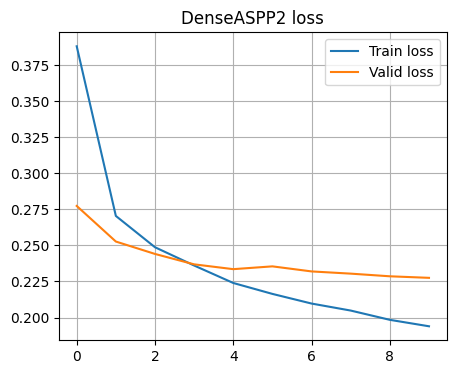

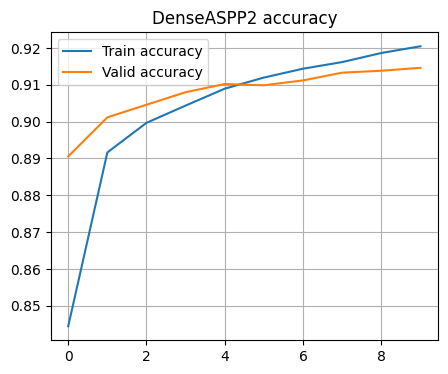

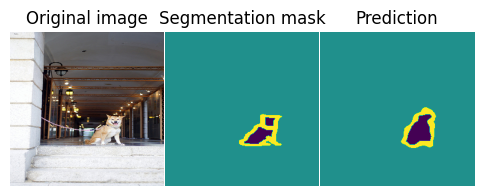

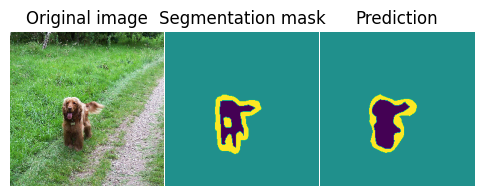

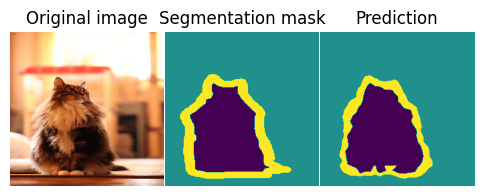

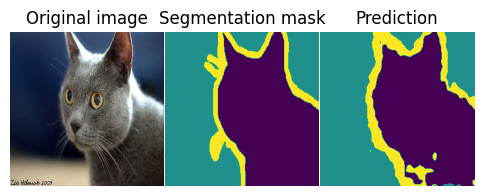

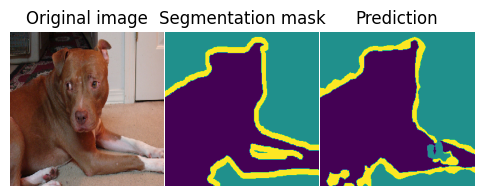

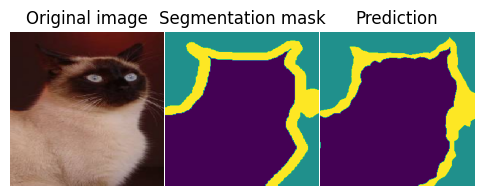

In [ ]:
model_denseaspp2 = model_denseaspp2.to(device)

whole_train_valid_cycle(model=model_denseaspp2,
                        num_epochs=N_EPOCHS,
                        train_loader=train_loader,
                        valid_loader=valid_loader,
                        test_loader=test_loader,
                        optimizer=optimizer_denseaspp2,
                        criterion=loss_fn,
                        device=device,
                        title=title_denseaspp2,
                        model_type='DenseASPP',
                        scheduler=scheduler_denseaspp2,
                        save=True)

## CutDenseASPP1

This model is a modification with respect to the original DenseASPP1. In this case, it shortens the head, so it only concatenates the convolutions with 3, 6 and 12 as the dilation parameter.

As this version is shorter with respect to the previous example, to balance this modification, I will also use a longer backbone (that will remain frozen). This way, we can test how important the head is with respect to the backbone.

In [ ]:
# Definition of a modified DenseASPPBlock without aspp_18 and aspp_24
class CutDenseASPPBlock(nn.Module):
    def __init__(self, original_block):
        super(CutDenseASPPBlock, self).__init__()
        self.aspp_3 = original_block.aspp_3
        self.aspp_6 = original_block.aspp_6
        self.aspp_12 = original_block.aspp_12

    def forward(self, x):
        aspp3 = self.aspp_3(x)
        x = torch.cat([aspp3, x], dim=1)

        aspp6 = self.aspp_6(x)
        x = torch.cat([aspp6, x], dim=1)

        aspp12 = self.aspp_12(x)
        x = torch.cat([aspp12, x], dim=1)

        return x

In [ ]:
title_cutdenseaspp1 = 'CutDenseASPP1'

In [ ]:
# Loading the original pretrained model
model_cutdenseaspp1 = get_denseaspp('pascal_aug', 'densenet161')

# Replacing the dense_aspp_block in the loaded model
original_block = model_cutdenseaspp1.head.dense_aspp_block
model_cutdenseaspp1.head.dense_aspp_block = CutDenseASPPBlock(original_block)

# Updating the final convolutional layer (used for classification) to match the new number of input channels
# It receives the original input and the output of each of the convolutional blocks.
in_channels_last_layer =  original_block.aspp_3.conv1.in_channels + 3 * original_block.aspp_12.conv2.out_channels
model_cutdenseaspp1.head.block = nn.Sequential(
    nn.Dropout(0.1),
    nn.Conv2d(in_channels_last_layer, num_classes, 1))

# Print the updated model
print(model_cutdenseaspp1)

Downloading: "https://download.pytorch.org/models/densenet161-8d451a50.pth" to /root/.cache/torch/hub/checkpoints/densenet161-8d451a50.pth
100%|██████████| 110M/110M [00:00<00:00, 187MB/s]


DenseASPP(
  (pretrained): DilatedDenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05,

The approach is to train all the head weights. All the parameters from the backbone are frozen.

In [ ]:
# Freeze the backbone weights
for param in model_cutdenseaspp1.pretrained.parameters():
    param.requires_grad = False

# Ensure the head's parameters are trainable
for param in model_cutdenseaspp1.head.parameters():
    param.requires_grad = True

# Optionally, verify that the parameters are correctly set
#for name, param in model_cutdenseaspp1.named_parameters():
#    print(f"{name}: requires_grad={param.requires_grad}")

In [ ]:
print(f"The model has {count_parameters(model_cutdenseaspp1):,} trainable parameters.")

The model has 2,197,347 trainable parameters.


In [ ]:
print(f"The model has {count_total_parameters(model_cutdenseaspp1):,} (total) parameters.")

The model has 30,878,347 (total) parameters.


### Optimizer setup

In all DenseASPP models, I am using the same optimizer defined in the DenseASPP paper.

In [ ]:
optimizer_cutdenseaspp1 = Adam(model_cutdenseaspp1.parameters(), lr=initial_lr, weight_decay=weight_decay)

scheduler_cutdenseaspp1 = LambdaLR(optimizer_cutdenseaspp1, lr_lambda=lr_lambda)

### Training the model

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 1/10 -- Epoch Time: 308.92 s
---------------------------------
Train -- Loss: 0.423, Acc: 83.18%
Val -- Loss: 0.304, Acc: 87.27%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP1.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 2/10 -- Epoch Time: 311.74 s
---------------------------------
Train -- Loss: 0.301, Acc: 87.75%
Val -- Loss: 0.275, Acc: 88.63%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP1.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 3/10 -- Epoch Time: 309.50 s
---------------------------------
Train -- Loss: 0.278, Acc: 88.63%
Val -- Loss: 0.266, Acc: 89.00%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP1.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 4/10 -- Epoch Time: 310.64 s
---------------------------------
Train -- Loss: 0.264, Acc: 89.17%
Val -- Loss: 0.257, Acc: 89.39%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP1.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 5/10 -- Epoch Time: 311.92 s
---------------------------------
Train -- Loss: 0.253, Acc: 89.63%
Val -- Loss: 0.250, Acc: 89.71%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP1.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 6/10 -- Epoch Time: 311.01 s
---------------------------------
Train -- Loss: 0.243, Acc: 89.99%
Val -- Loss: 0.249, Acc: 89.76%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP1.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 7/10 -- Epoch Time: 311.40 s
---------------------------------
Train -- Loss: 0.236, Acc: 90.27%
Val -- Loss: 0.245, Acc: 89.98%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP1.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 8/10 -- Epoch Time: 311.45 s
---------------------------------
Train -- Loss: 0.229, Acc: 90.55%
Val -- Loss: 0.244, Acc: 90.07%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP1.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 9/10 -- Epoch Time: 310.80 s
---------------------------------
Train -- Loss: 0.224, Acc: 90.76%
Val -- Loss: 0.242, Acc: 90.17%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP1.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 10/10 -- Epoch Time: 310.78 s
---------------------------------
Train -- Loss: 0.219, Acc: 90.94%
Val -- Loss: 0.243, Acc: 90.18%

Total training time (CutDenseASPP1): 3133.73 s

--------------------------------------------------------------
Final training results


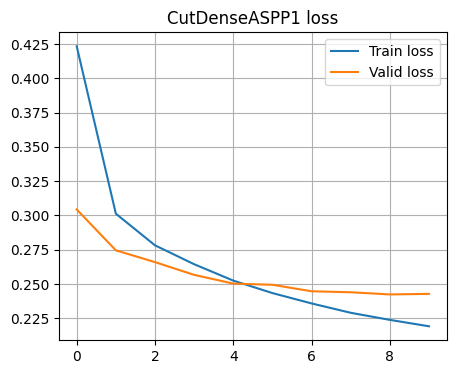

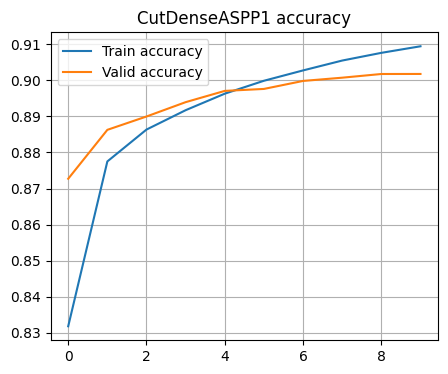

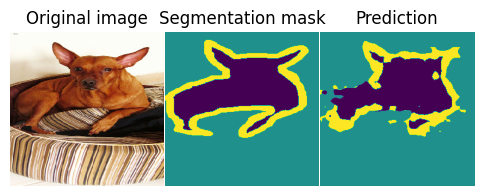

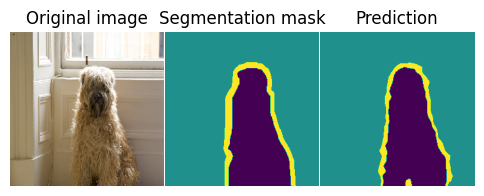

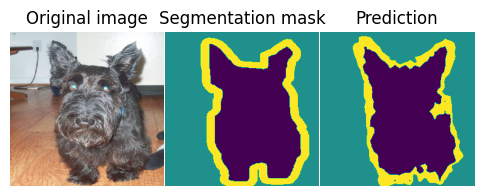

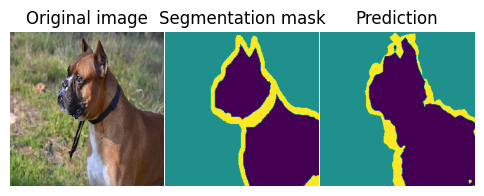

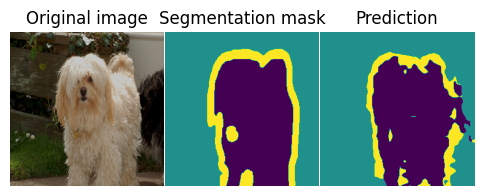

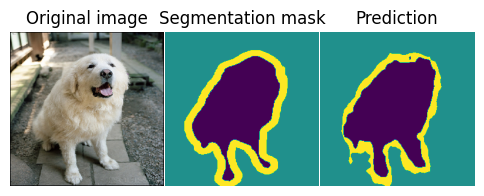

In [ ]:
model_cutdenseaspp1 = model_cutdenseaspp1.to(device)

whole_train_valid_cycle(model=model_cutdenseaspp1,
                        num_epochs=N_EPOCHS,
                        train_loader=train_loader,
                        valid_loader=valid_loader,
                        test_loader=test_loader,
                        optimizer=optimizer_cutdenseaspp1,
                        criterion=loss_fn,
                        device=device,
                        title=title_cutdenseaspp1,
                        model_type='DenseASPP',
                        scheduler=scheduler_cutdenseaspp1,
                        save=True)

## CutDenseASPP2

This model has the same architecture as the CutDenseASPP1. The only difference is that the head elements were pretrained with a different dataset.

In [ ]:
title_cutdenseaspp2 = 'CutDenseASPP2'

In [ ]:
# Loading the original pretrained model
model_cutdenseaspp2 = get_denseaspp('ade20k', 'densenet161')

# Replacing the dense_aspp_block in the loaded model
original_block = model_cutdenseaspp1.head.dense_aspp_block
model_cutdenseaspp2.head.dense_aspp_block = CutDenseASPPBlock(original_block)

# Updating the final convolutional layer (used for classification) to match the new number of input channels
# It receives the original input and the output of each of the convolutional blocks.
in_channels_last_layer =  original_block.aspp_3.conv1.in_channels + 3 * original_block.aspp_12.conv2.out_channels
model_cutdenseaspp2.head.block = nn.Sequential(
    nn.Dropout(0.1),
    nn.Conv2d(in_channels_last_layer, num_classes, 1))

# Print the updated model
print(model_cutdenseaspp2)

DenseASPP(
  (pretrained): DilatedDenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(144, eps=1e-05,

The approach is to train all the head weights. All the parameters from the backbone are frozen.

In [ ]:
# Freeze the backbone weights
for param in model_cutdenseaspp2.pretrained.parameters():
    param.requires_grad = False

# Ensure the head's parameters are trainable
for param in model_cutdenseaspp2.head.parameters():
    param.requires_grad = True

# Optionally, verify that the parameters are correctly set
#for name, param in model_cutdenseaspp2.named_parameters():
#    print(f"{name}: requires_grad={param.requires_grad}")

In [ ]:
print(f"The model has {count_parameters(model_cutdenseaspp2):,} trainable parameters.")

The model has 2,197,347 trainable parameters.


In [ ]:
print(f"The model has {count_total_parameters(model_cutdenseaspp2):,} (total) parameters.")

The model has 30,878,347 (total) parameters.


### Optimizer setup

In all DenseASPP1 models, I am using the same optimizer defined in the DenseASPP paper.

In [ ]:
optimizer_cutdenseaspp2 = Adam(model_cutdenseaspp2.parameters(), lr=initial_lr, weight_decay=weight_decay)

scheduler_cutdenseaspp2 = LambdaLR(optimizer_cutdenseaspp2, lr_lambda=lr_lambda)

### Training the model


Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 1/10 -- Epoch Time: 311.77 s
---------------------------------
Train -- Loss: 0.345, Acc: 86.76%
Val -- Loss: 0.256, Acc: 89.58%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP2.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 2/10 -- Epoch Time: 312.28 s
---------------------------------
Train -- Loss: 0.250, Acc: 89.84%
Val -- Loss: 0.252, Acc: 89.69%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP2.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 3/10 -- Epoch Time: 309.70 s
---------------------------------
Train -- Loss: 0.235, Acc: 90.34%
Val -- Loss: 0.243, Acc: 90.07%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP2.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 4/10 -- Epoch Time: 312.26 s
---------------------------------
Train -- Loss: 0.227, Acc: 90.68%
Val -- Loss: 0.240, Acc: 90.21%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP2.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 5/10 -- Epoch Time: 313.73 s
---------------------------------
Train -- Loss: 0.219, Acc: 90.96%
Val -- Loss: 0.238, Acc: 90.33%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP2.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 6/10 -- Epoch Time: 313.10 s
---------------------------------
Train -- Loss: 0.213, Acc: 91.19%
Val -- Loss: 0.237, Acc: 90.43%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP2.pt



Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 7/10 -- Epoch Time: 310.86 s
---------------------------------
Train -- Loss: 0.209, Acc: 91.37%
Val -- Loss: 0.238, Acc: 90.41%




Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 8/10 -- Epoch Time: 310.15 s
---------------------------------
Train -- Loss: 0.204, Acc: 91.55%
Val -- Loss: 0.239, Acc: 90.48%




Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 9/10 -- Epoch Time: 308.50 s
---------------------------------
Train -- Loss: 0.201, Acc: 91.69%
Val -- Loss: 0.237, Acc: 90.57%




Training (current epoch):   0%|          | 0/230 [00:00<?, ?it/s]

Evaluation (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Epoch: 10/10 -- Epoch Time: 309.80 s
---------------------------------
Train -- Loss: 0.197, Acc: 91.83%
Val -- Loss: 0.237, Acc: 90.58%

Validation loss improved. Model saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Models/CutDenseASPP2.pt

--------------------------------------------------------------
Final training results:
Total training time (CutDenseASPP2): 3119.03 s


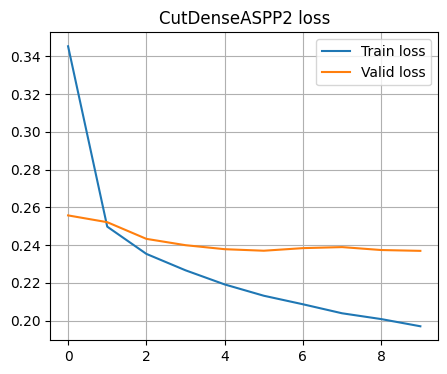

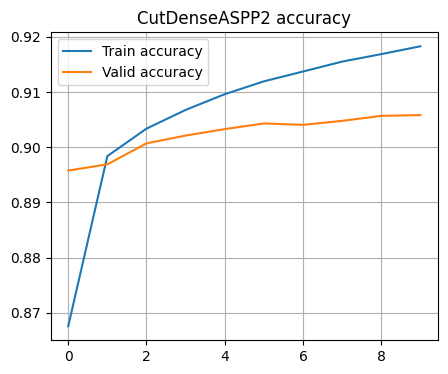

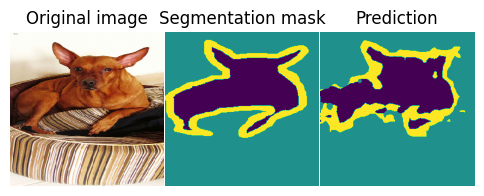

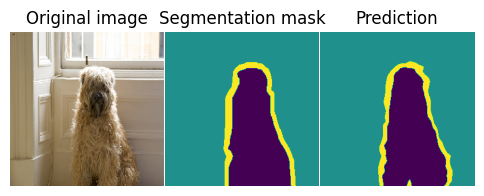

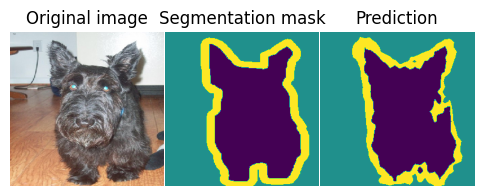

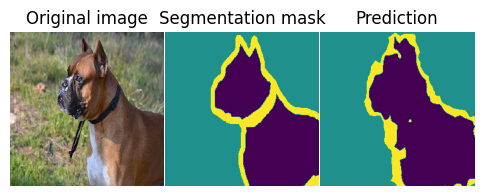

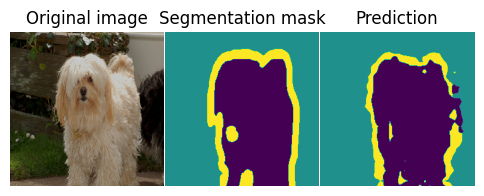

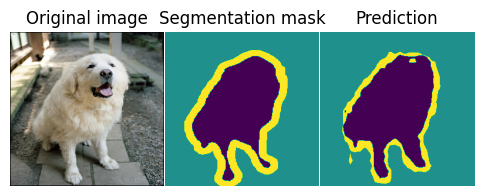

In [ ]:
model_cutdenseaspp2 = model_cutdenseaspp2.to(device)

whole_train_valid_cycle(model=model_cutdenseaspp2,
                        num_epochs=N_EPOCHS,
                        train_loader=train_loader,
                        valid_loader=valid_loader,
                        test_loader=test_loader,
                        optimizer=optimizer_cutdenseaspp2,
                        criterion=loss_fn,
                        device=device,
                        title=title_cutdenseaspp2,
                        model_type='DenseASPP',
                        scheduler=scheduler_cutdenseaspp2,
                        save=True)

# Performance evaluation

## Model loading

Loading the best version of the models. Then the predictions are made to compute the Mean Intersection over Union (mIoU) metric.

In [ ]:
def load_model_state(model, title):
  # A copy in case you want two different versions of the same model
  # (the one in currently memory and the one that is loaded)
  loaded_mode = copy.deepcopy(model)

  # Getting the path to load the model
  filename = title + '.pt'
  model_load_path = os.path.join(models_dir, filename)

  # Loading the model and ensuring that it is passed to the device
  loaded_mode.load_state_dict(torch.load(model_load_path, map_location=device))
  loaded_mode.to(device)

  return loaded_mode

In [ ]:
FCN_Res50 = load_model_state(model=FCN_Res50, title=title_FCNresnet50)
DLab_Res50 = load_model_state(model=DLab_Res50, title=title_Deeplabv3)
model_denseaspp1 = load_model_state(model=model_denseaspp1, title=title_denseaspp1)
model_denseaspp2 = load_model_state(model=model_denseaspp2, title=title_denseaspp2)
model_cutdenseaspp1 = load_model_state(model=model_cutdenseaspp1, title=title_cutdenseaspp1)
model_cutdenseaspp2 = load_model_state(model=model_cutdenseaspp2, title=title_cutdenseaspp2)

Some key functions for assessing the performance of each model are defined below.

## Predictions, pixel accuracy and weighted mIoU

I tried to obtain all the predictions and the compute the overall accuracy and mIoU. However, because the outputs are images with many pixels, when aggregating them to compute the final metrics, I was running into memory issues.

For that reason, the following function computes those metrics incrementally: it adds the cumulative measures as it is processing and predicting each batch.

Also, I computed the accuracy manually to go over the dataloaders just once, when computing the predictions (if I used the evaluation function, it would go over the dataset twice).

In [ ]:
@torch.inference_mode()
def predict_and_compute_metrics(model: nn.Module, loader: DataLoader, device: torch.device, model_type: str = 'FCN', num_classes: int = num_classes):

  model.eval()

  # Initializing counters for pixel accuracy
  correct = 0
  total_elements = 0

  # Initializing counters for the IoU (I use a counter for the class frequencies to weigh the final mIoU)
  intersection = torch.zeros(num_classes, dtype=torch.float64).to(device)
  union = torch.zeros(num_classes, dtype=torch.float64).to(device)
  class_freq = torch.zeros(num_classes, dtype=torch.float64).to(device)

  #-----------------------------------------------------------------------------
  # Starting the loop over the dataset
  start_time_pred = time.time()

  for x, y in tqdm(loader, desc='Predicting (current epoch)'):
    x = x.to(device)
    y = y.to(device).squeeze(1)

    # The output is formatted in a different way depending on the type of model
    if model_type == 'DenseASPP':
      output = model(x)
    else:
      output = model(x)['out']

    # Getting the class with the highest score
    _, pred_class = torch.max(output, dim=1)

    # Incremental computation of pixel accuracy
    correct += (pred_class == y).sum().item()
    total_elements += y.numel()

    # Incremental computation of IoU
    # For each class and each image, it computes the intersection and the union and accumulates them
    # Later on, the overall IoU for each class is computed.
    for cls in range(num_classes):
      pred_mask = (pred_class == cls)
      target_mask = (y == cls)
      intersection[cls] += (pred_mask & target_mask).sum().item()
      union[cls] += (pred_mask | target_mask).sum().item()
      class_freq[cls] += target_mask.sum().item()

    # Clearing GPU memory to avoid problems
    del x, y, output, pred_class
    torch.cuda.empty_cache()

  end_time_pred = time.time()
  prediction_time = end_time_pred - start_time_pred
  print(f'Total prediction time: {prediction_time:.2f} s')

  # Computing final accuracy
  accuracy = correct / total_elements

  # Computing final IoU for each class and then the weighted mIoU (the average across classes)
  iou_per_class = intersection / (union + 1e-10)

  total_class_pixels = class_freq.sum()
  weights = class_freq / total_class_pixels
  miou = (iou_per_class * weights).sum().item()

  return accuracy, miou, prediction_time


In [ ]:
def compute_results(model, title, save=False, model_type='FCN', num_classes=num_classes):

  # Computing the predictions
  accuracy, miou, prediction_time = predict_and_compute_metrics(model, test_loader, device, model_type=model_type, num_classes=num_classes)

  # Organizing the results in a dictionary
  results = {'Model':title,
             'Pixel accuracy':accuracy,
             'Weighted mIoU':miou,
             'Prediction time (s)':prediction_time}

  # Visualizing some examples
  visualize(model, next(iter(test_loader)), model_type=model_type)

  if save:
    filename_results = os.path.join(results_dir, title + '_results.json')
    with open(filename_results, 'w') as f:
      json.dump(results, f, indent=4)
    print(f'\nResults object saved as {filename_results}')

  return results

## Test results FCN

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Predicting (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Total prediction time: 36.78 s


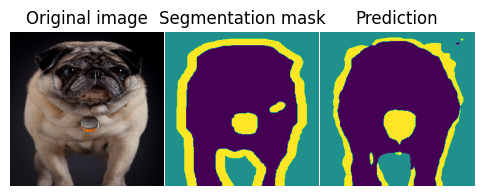

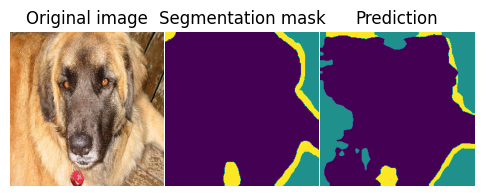

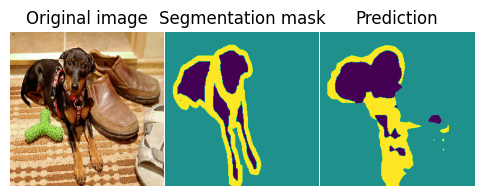

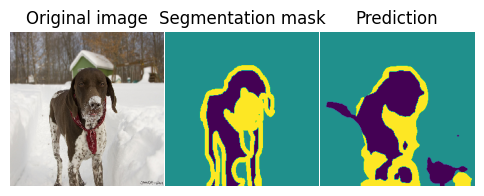

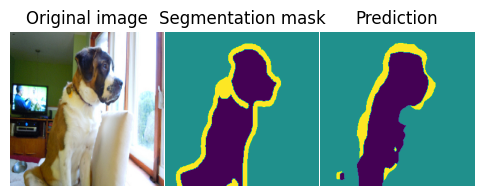

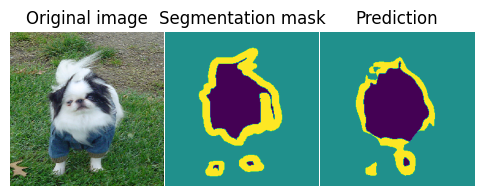


Results object saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Results/FCN - Resnet50 segmentation_results.json


{'Model': 'FCN - Resnet50 segmentation',
 'Pixel accuracy': 0.8866840807666175,
 'Weighted mIoU': 0.8045309829150984,
 'Prediction time (s)': 36.78428936004639}

In [ ]:
results_FCN = compute_results(model=FCN_Res50,
                              title=title_FCNresnet50,
                              save=True)
results_FCN

## Test results DeepLab

Predicting (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Total prediction time: 47.60 s


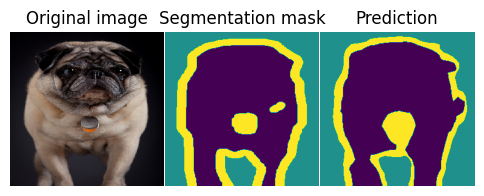

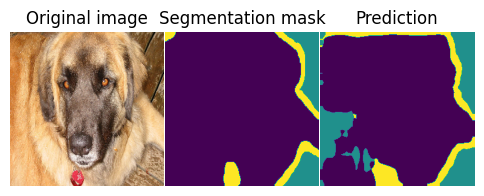

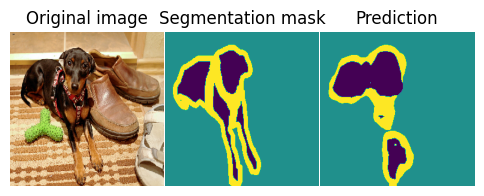

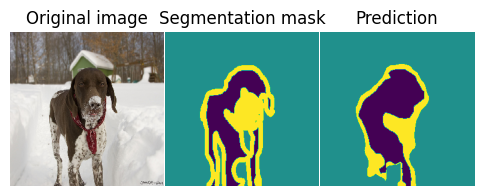

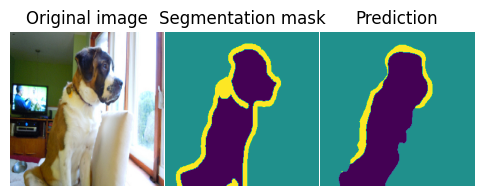

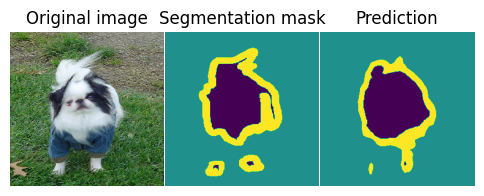


Results object saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Results/Deeplabv3 - Resnet50 segmentation_results.json


{'Model': 'Deeplabv3 - Resnet50 segmentation',
 'Pixel accuracy': 0.8936389353179099,
 'Weighted mIoU': 0.8171375974362629,
 'Prediction time (s)': 47.60010051727295}

In [ ]:
results_Deeplabv3 = compute_results(model=DLab_Res50,
                                     title=title_Deeplabv3,
                                     save=True)
results_Deeplabv3

## Test results DenseASPP1


Predicting (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Total prediction time: 27.63 s


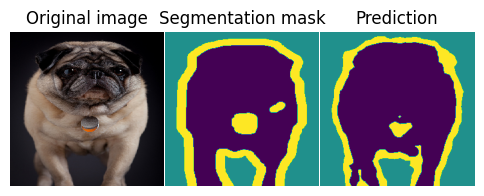

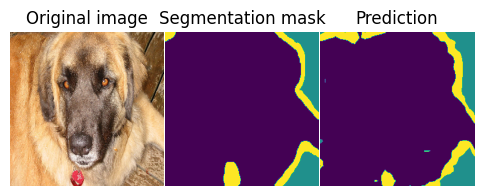

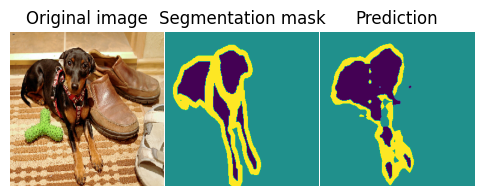

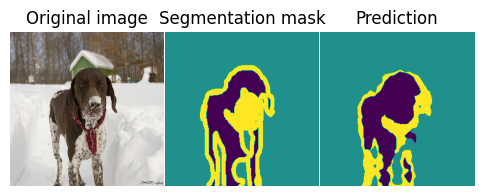

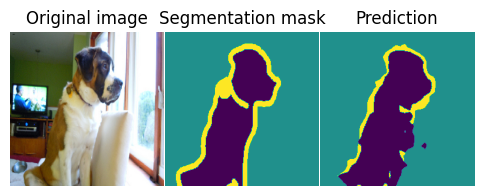

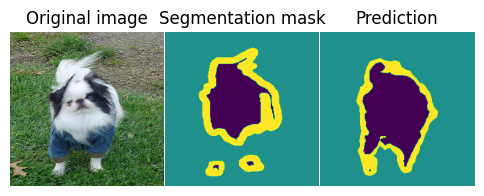


Results object saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Results/DenseASPP1_results.json


{'Model': 'DenseASPP1',
 'Pixel accuracy': 0.9168118858545401,
 'Weighted mIoU': 0.8543427736303453,
 'Prediction time (s)': 27.626213550567627}

In [ ]:
results_denseaspp1 = compute_results(model=model_denseaspp1,
                                     title=title_denseaspp1,
                                     save=True,
                                     model_type='DenseASPP')
results_denseaspp1

## Test results DenseASPP2


Predicting (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Total prediction time: 28.57 s


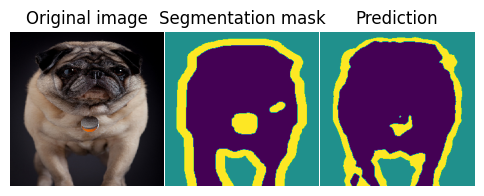

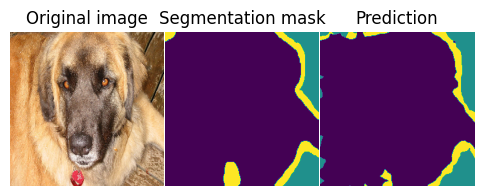

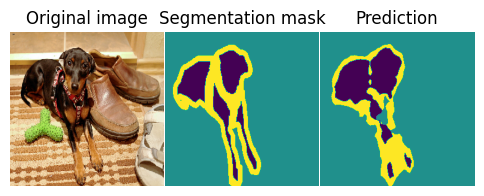

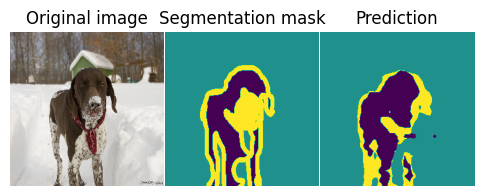

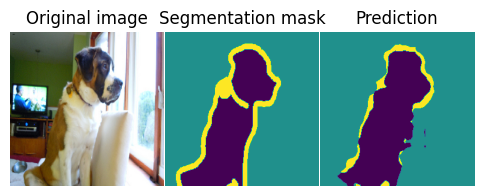

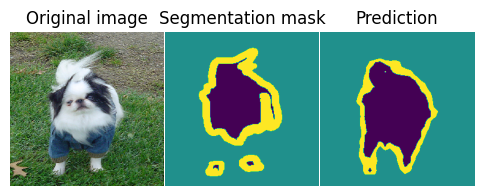


Results object saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Results/DenseASPP2_results.json


{'Model': 'DenseASPP2',
 'Pixel accuracy': 0.9164265889507863,
 'Weighted mIoU': 0.853362952940836,
 'Prediction time (s)': 28.566851139068604}

In [ ]:
results_denseaspp2 = compute_results(model=model_denseaspp2,
                                     title=title_denseaspp2,
                                     save=True,
                                     model_type='DenseASPP')
results_denseaspp2

## Test results CutDenseASPP1


Predicting (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Total prediction time: 57.06 s


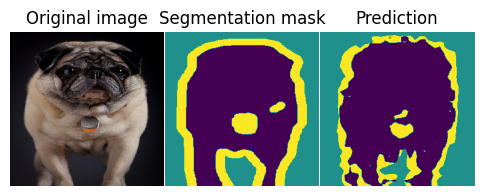

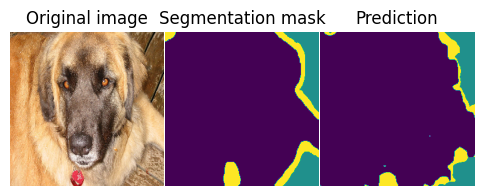

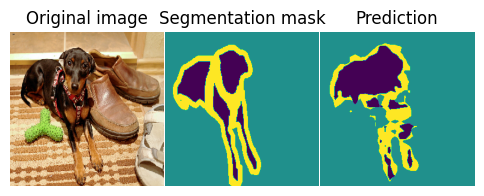

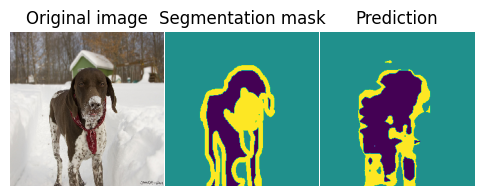

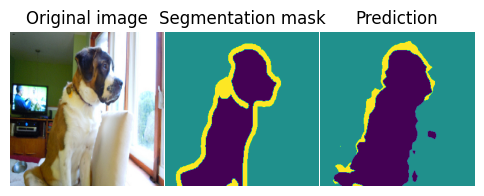

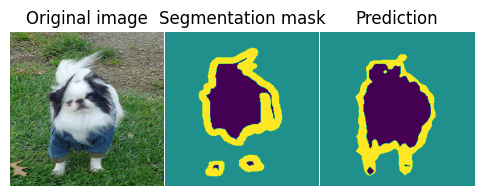


Results object saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Results/CutDenseASPP1_results.json


{'Model': 'CutDenseASPP1',
 'Pixel accuracy': 0.9016604907120067,
 'Weighted mIoU': 0.8310957247949236,
 'Prediction time (s)': 57.06094217300415}

In [ ]:
results_cutdenseaspp1 = compute_results(model=model_cutdenseaspp1,
                                        title=title_cutdenseaspp1,
                                        save=True,
                                        model_type='DenseASPP')
results_cutdenseaspp1

## Test results CutDenseASPP2


Predicting (current epoch):   0%|          | 0/58 [00:00<?, ?it/s]

Total prediction time: 56.60 s


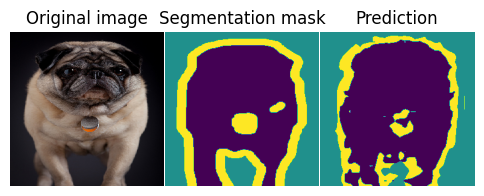

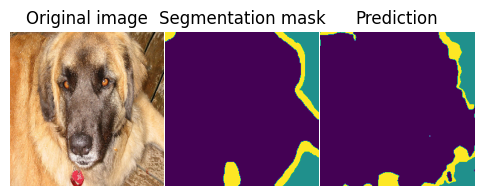

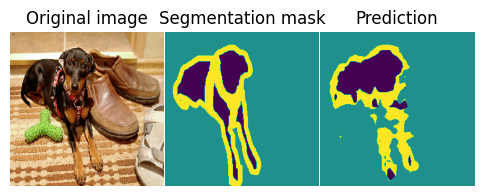

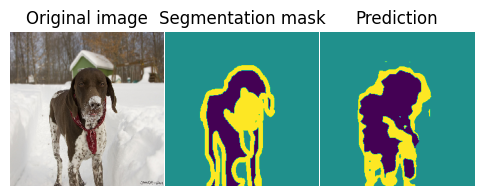

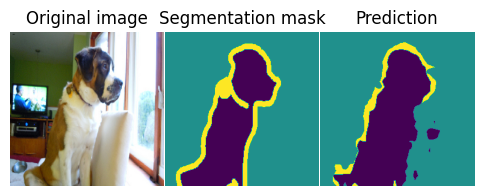

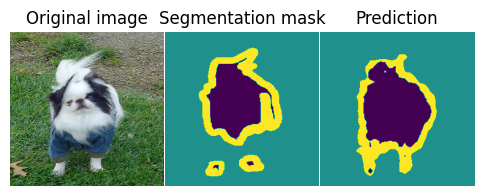


Results object saved as /content/drive/My Drive/Unipd/VCS/VCS PROJECT/Saving folder/Results/CutDenseASPP2_results.json


{'Model': 'CutDenseASPP2',
 'Pixel accuracy': 0.9057454948466893,
 'Weighted mIoU': 0.8381379962681528,
 'Prediction time (s)': 56.600050926208496}

In [ ]:
results_cutdenseaspp2 = compute_results(model=model_cutdenseaspp2,
                                        title=title_cutdenseaspp2,
                                        save=True,
                                        model_type='DenseASPP')
results_cutdenseaspp2

# Results summary

Formatting the results in a single table

In [ ]:
def results_summary(list_results, save=False):
  df = pd.DataFrame(list_results)
  df = df[['Model','Pixel accuracy','Weighted mIoU','Prediction time (s)']]
  df = df.round(3)
  if save:
    filename_results = os.path.join(results_dir, 'Final results.csv')
    df.to_csv(filename_results, index=False)
  return df



list_results = [results_FCN, results_Deeplabv3,
                results_denseaspp1, results_denseaspp2,
                results_cutdenseaspp1, results_cutdenseaspp2]
final_results = results_summary(list_results, save=False)
final_results

Model  Pixel accuracy  Weighted mIoU  \
0        FCN - Resnet50 segmentation           0.887          0.805   
1  Deeplabv3 - Resnet50 segmentation           0.894          0.817   
2                         DenseASPP1           0.917          0.854   
3                         DenseASPP2           0.916          0.853   
4                      CutDenseASPP1           0.902          0.831   
5                      CutDenseASPP2           0.906          0.838   

   Prediction time (s)  
0               36.784  
1               47.600  
2               27.626  
3               28.567  
4               57.061  
5               56.600

# Demo with some other examples

In [ ]:
!unzip "/content/drive/My Drive/Unipd/VCS/VCS PROJECT/animal_seg_examples" -d "/content/animal_seg_examples"

Archive:  /content/drive/My Drive/Unipd/VCS/VCS PROJECT/animal_seg_examples.zip
  inflating: /content/animal_seg_examples/photo1720172107 (1).jpeg  
  inflating: /content/animal_seg_examples/photo1720172107 (2).jpeg  
  inflating: /content/animal_seg_examples/photo1720172107 (3).jpeg  
  inflating: /content/animal_seg_examples/photo1720172107 (4).jpeg  
  inflating: /content/animal_seg_examples/photo1720172107.jpeg  
  inflating: /content/animal_seg_examples/photo1720172228.jpeg  
  inflating: /content/animal_seg_examples/photo1720172309.jpeg  
  inflating: /content/animal_seg_examples/photo1720172450.jpeg  
  inflating: /content/animal_seg_examples/photo1720172533.jpeg  


In [ ]:
own_examples_dir = "/content/animal_seg_examples"
example_images = [img for img in os.listdir(own_examples_dir)]

In [ ]:
def visualize_examples(model, directory, img_filenames, model_type='FCN', num_images=9):

  transforms = T.Compose([T.Resize(IMAGE_SIZE, interpolation=T.InterpolationMode.NEAREST),
                        T.ToTensor(),
                        T.Normalize([mean_r, mean_g, mean_b], [std_r, std_g, std_b])])
  to_pil = T.ToPILImage()
  to_tensor = T.ToTensor()

  unnormalize = T.Compose([T.Normalize(mean = [0., 0., 0.], std = [1/std_r, 1/std_g, 1/std_b]),
                          T.Normalize(mean = [-mean_r, -mean_g, -mean_b], std = [1., 1., 1.])])

  for i, img_filename in enumerate(img_filenames):

    if i < num_images:
      file_path = os.path.join(directory, img_filename)

      img = Image.open(file_path)

      resize = T.Resize((img.size[1],img.size[0]), interpolation=T.InterpolationMode.NEAREST)

      img_tensor = transforms(img).to(device)
      img_input = img_tensor.unsqueeze(0)

      # The output is formatted in a different way depending on the type of model
      if model_type == 'DenseASPP':
        output = model(img_input)
      else:
        output = model(img_input)['out']

      #output = FCN_Res50(img_input)['out']
      pred_class = torch.max(output, dim=1)[1]

      pred_class_resized = resize(pred_class)

      mask_pet = (pred_class_resized == 0)
      mask_border = (pred_class_resized == 2)
      mask = mask_pet | mask_border
      masked_img = torchvision.utils.draw_segmentation_masks(image=to_tensor(img.convert('RGB')), masks=torch.stack((mask_pet,mask_border)).squeeze(1), alpha=0.4, colors=["purple","yellow"])

      fig, ax = plt.subplots(1, 2, figsize=(6, 6), facecolor='white')

      ax[0].imshow(img)
      ax[1].imshow(masked_img.permute(1,2,0))

      for axis in ax:
        axis.axis('off')

      ax[0].set_title('Original image')
      ax[1].set_title('Prediction with mask')

      plt.tight_layout(pad=3.0)
      plt.show()


## Demo FCN

In [ ]:
visualize_examples(model=FCN_Res50,
                   directory=own_examples_dir, img_filenames=example_images)

Output hidden; open in https://colab.research.google.com to view.

## Demo DeepLab

In [ ]:
visualize_examples(model=DLab_Res50,
                   directory=own_examples_dir, img_filenames=example_images)

Output hidden; open in https://colab.research.google.com to view.

## Demo DenseASPP1

In [ ]:
visualize_examples(model=model_denseaspp1,
                   directory=own_examples_dir, img_filenames=example_images,
                   model_type='DenseASPP')

Output hidden; open in https://colab.research.google.com to view.

## Demo DenseASPP2

In [ ]:
visualize_examples(model=model_denseaspp2,
                   directory=own_examples_dir, img_filenames=example_images,
                   model_type='DenseASPP')

Output hidden; open in https://colab.research.google.com to view.

## Demo CutDenseASPP1

In [ ]:
visualize_examples(model=model_cutdenseaspp1,
                   directory=own_examples_dir, img_filenames=example_images,
                   model_type='DenseASPP')

Output hidden; open in https://colab.research.google.com to view.

## Demo CutDenseASPP2

In [ ]:
visualize_examples(model=model_cutdenseaspp2,
                   directory=own_examples_dir, img_filenames=example_images,
                   model_type='DenseASPP')

Output hidden; open in https://colab.research.google.com to view.